# Predicting Flight Delay

Problem Set-up:
We define a delayed flight to be one that is delayed by >= 15 minutes. 
The prediction problem is to train a model that can classify flights, to predict if they will or will not be delayed.

Use case:
- The idea is that this model would be useful to choosing airlines, flightpaths, airports, at the time of booking, relatively in advance of the scheduled departure (days, weeks, months ahead of time). Therefore, the prediction problem will focus on features that can be known in advance, rather than predicting using day-off features like weather and previous flights from that day. 

Notes:
- We restrict the analysis to relatively large airport, those with more than 20 (domestic) flights a day

# This notebook: more features
* one-hot day of week
* one-hot month
* one-hot airline
* one-hot airport
* one-hot departure hour

In [114]:
# Imports
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style('white')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [2]:
# Import custom code
from flightdelay.fld import io as flio

# Load data

In [3]:
airlines_df, airports_df, flights_df = flio.load_data()

In [4]:
# Filter data to keys of interest
keys = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY']
flights_df = flights_df[keys]

In [5]:
flights_df = flights_df.dropna()

In [6]:
flights_df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,...,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,...,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0
2,1,1,4,US,840,N171US,SFO,CLT,20,18.0,...,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0
3,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,...,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0
4,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,...,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0


In [7]:
N_flights = 1000000
N_train = int(N_flights/2)
np.random.seed(0)
flight_take_idx = np.random.permutation(flights_df.index)[:N_flights]
df_trainval = flights_df.loc[flight_take_idx]

In [8]:
df_trainval.head(20)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
2167050,5,18,1,OO,2898,N866AS,LAX,SMF,1030,1027.0,...,1045.0,86.0,85.0,63.0,373,1148.0,4.0,1156,1152.0,-4.0
1395129,3,31,2,DL,228,N945DL,MCO,CVG,1321,1315.0,...,1325.0,129.0,133.0,119.0,757,1524.0,4.0,1530,1528.0,-2.0
2771766,6,23,2,DL,1812,N955DN,ATL,ORD,2205,2210.0,...,2229.0,123.0,114.0,89.0,606,2258.0,6.0,2308,2304.0,-4.0
5181045,11,20,5,EV,4869,N738EV,DTW,TVC,1200,1156.0,...,1208.0,67.0,58.0,43.0,207,1251.0,3.0,1307,1254.0,-13.0
947404,3,4,3,UA,283,N549UA,SFO,IAH,601,557.0,...,612.0,223.0,216.0,196.0,1635,1128.0,5.0,1144,1133.0,-11.0
3218377,7,20,1,WN,1119,N365SW,MKE,DAL,1800,1859.0,...,1909.0,145.0,144.0,129.0,850,2118.0,5.0,2025,2123.0,58.0
2666917,6,17,3,UA,1954,N16703,DCA,IAH,1744,2046.0,...,2113.0,200.0,198.0,161.0,1208,2254.0,10.0,2004,2304.0,180.0
3732761,8,20,4,WN,910,N703SW,SMF,LAX,1000,1011.0,...,1021.0,85.0,79.0,64.0,373,1125.0,5.0,1125,1130.0,5.0
3950971,9,2,3,DL,2065,N925AT,LAX,SEA,1910,1908.0,...,1923.0,162.0,152.0,128.0,954,2131.0,9.0,2152,2140.0,-12.0
4241971,9,21,1,WN,213,N791SW,DAL,DEN,1940,1944.0,...,1955.0,125.0,113.0,93.0,651,2028.0,9.0,2045,2037.0,-8.0


# Randomly take subset of data

# Compute features
* one-hot day of week
* one-hot month
* one-hot airline
* one-hot airport
* one-hot departure hour

### 0. Original feat

In [9]:
original_feat = {'f_distance':df_trainval['DISTANCE'].values}

In [57]:
y_delay = df_trainval['DEPARTURE_DELAY'].values
y_delay01 = y_delay > 15

### 1. Day of week

In [11]:
def make_onehot_feat_dict(df, feat_key, feat_name):
    # Create features for each day of the week
    feat_vals = df[feat_key].values
    all_vals = np.unique(feat_vals)
    N_vals = len(all_vals)
    N_feat = N_vals - 1

    # Create keys
    keys = [0]*N_feat
    for i in range(N_feat):
        keys[i] = 'f_'+feat_name+'_'+ str(all_vals[i])

    # Create value for each training example in dict
    feat_dict = {}
    for i, k in enumerate(keys):
        this_day = all_vals[i]
        feat_dict[k] = feat_vals == this_day
    return feat_dict

In [12]:
daysfeat_dict = make_onehot_feat_dict(df_trainval, 'DAY_OF_WEEK', 'day')

### 2. Month

In [13]:
monthsfeat_dict = make_onehot_feat_dict(df_trainval, 'MONTH', 'month') 

### 3. Departing airport

In [14]:
dapfeat_dict = make_onehot_feat_dict(df_trainval, 'ORIGIN_AIRPORT', 'dap') 

### 4. Airline

In [15]:
alfeat_dict = make_onehot_feat_dict(df_trainval, 'AIRLINE', 'al') 

### 5. Departure hour

In [16]:
# Add departure hour as a feature
df_trainval['HOUR_DEPARTURE'] = np.floor(df_trainval['SCHEDULED_DEPARTURE'].values/100).astype(int)
df_trainval['HOUR_ARRIVAL'] = np.floor(df_trainval['SCHEDULED_ARRIVAL'].values/100).astype(int)
hrfeat_dict = make_onehot_feat_dict(df_trainval, 'HOUR_DEPARTURE', 'hr')

# Save new feature matrix

In [17]:
all_dicts = [original_feat, daysfeat_dict, monthsfeat_dict, dapfeat_dict, alfeat_dict, hrfeat_dict]
feat_dict = all_dicts[0].copy()
for d in all_dicts[1:]:
    feat_dict.update(d)

In [32]:
df_feat = pd.DataFrame.from_dict(feat_dict)
df_feat.head()

,f_al_AA,f_al_AS,f_al_B6,f_al_DL,f_al_EV,f_al_F9,f_al_HA,f_al_MQ,f_al_NK,f_al_OO,...,f_month_10,f_month_11,f_month_2,f_month_3,f_month_4,f_month_5,f_month_6,f_month_7,f_month_8,f_month_9
0,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


#### Aside: Normalize features

In [98]:
# zscore all features
from scipy.stats import zscore
df_feat_zscore = df_feat.apply(zscore)

# Split data by airport

In [43]:
airport_keys = np.array(df_feat.keys()[df_feat.columns.str.startswith('f_dap')])
feat_keys = np.array(df_feat.keys()[~df_feat.columns.str.startswith('f_dap')])

In [93]:
ap_keys = [s[-3:] for s in airport_keys]

In [99]:
N_airports = len(airport_keys)
airport_dfs = {}
airport_y = {}
for k in airport_keys:
    airport_dfs[k[-3:]] = df_feat_zscore[feat_keys][df_feat[k].values]
    airport_y[k[-3:]] = y_delay01[df_feat[k].values]

In [96]:
Nflights_by_airport = {}
for k in ap_keys:
    Nflights_by_airport[k] = len(airport_y[k])

# Train model for each airport

In [154]:
all_models = {}
all_X_train = {}
all_X_val = {}
all_y_train = {}
all_y_val = {}
aps_trained_idx = []
all_Nflights = {}
min_Nflights_train = 1000
for i, ap in enumerate(ap_keys):
    
    # Compute number of training examples
    N_train = int(Nflights_by_airport[ap]*.7)
    
    if N_train >= 1000:
        print(ap, N_train)
        aps_trained_idx.append(i)
        all_Nflights[ap] = Nflights_by_airport[ap]
        # Declare DFs
        all_X_train[ap] = airport_dfs[ap].loc[airport_dfs[ap].index.values[:N_train]].values
        all_X_val[ap] = airport_dfs[ap].loc[airport_dfs[ap].index.values[N_train:]].values

        # Determine labels
        all_y_train[ap] = airport_y[ap][:N_train]
        all_y_val[ap] = airport_y[ap][N_train:]

        C = 1
        all_models[ap] = LogisticRegression(C=C)
        #model = LogisticRegression(C=C,fit_intercept=False)
        #model = LogisticRegression(C=C,class_weight='balanced')
        all_models[ap].fit(all_X_train[ap], all_y_train[ap])

ABQ 2545
ANC 2101
ATL 46378
AUS 5524
BDL 2445
BHM 1620
BNA 6115
BOI 1522
BOS 13935
BUF 2278
BUR 2450
BWI 11248
CHS 1551
CLE 4568
CLT 13459
CMH 3093
CVG 2623
DAL 7927
DAY 1107
DCA 9617
DEN 25911
DFW 30885
DSM 1099
DTW 14466
ELP 1514
EWR 13251
FLL 9604
GEG 1278
GRR 1425
HNL 5764
HOU 6764
IAD 4469
IAH 19170
ICT 1025
IND 3392
JAX 2415
JFK 12166
KOA 1446
LAS 17835
LAX 25608
LGA 12691
LGB 1171
LIH 1382
LIT 1379
MCI 5046
MCO 14506
MDW 10574
MEM 1928
MIA 9149
MKE 3880
MSN 1153
MSP 14758
MSY 5166
OAK 5630
OGG 2731
OKC 2074
OMA 2196
ONT 2403
ORD 37289
ORF 1260
PBI 2973
PDX 6310
PHL 8656
PHX 19159
PIT 3175
PSP 1190
PVD 1466
RDU 4115
RIC 1986
RNO 1659
ROC 1008
RSW 3515
SAN 9241
SAT 3934
SDF 1313
SEA 14919
SFO 19343
SJC 5064
SJU 3319
SLC 13003
SMF 5036
SNA 4974
STL 6204
TPA 8312
TUL 1796
TUS 2062
XNA 1206


# Evaluate model

### Concatanate predictions

In [215]:
ally_true = np.zeros(0)
ally_pred = np.zeros(0)
ally_predp = np.zeros(0)
for ap in all_models.keys():
    ally_true = np.append(ally_true,all_y_train[ap])
    ally_pred = np.append(ally_pred, all_models[ap].predict(all_X_train[ap]))
    ally_predp = np.append(ally_predp, all_models[ap].predict_proba(all_X_train[ap])[:,1])
    
ally_trueV = np.zeros(0)
ally_predV = np.zeros(0)
ally_predpV = np.zeros(0)
for ap in all_models.keys():
    ally_trueV = np.append(ally_trueV,all_y_val[ap])
    ally_predV = np.append(ally_predV, all_models[ap].predict(all_X_val[ap]))
    ally_predpV = np.append(ally_predpV, all_models[ap].predict_proba(all_X_val[ap])[:,1])

In [204]:
print('accuracy: ',1-sum(np.abs(ally_pred-ally_true))/len(ally_pred))

accuracy:  0.819589917475


In [205]:
ap_modelres = {}
ap_modelres['confuse'] = {}
ap_modelres['accuracy'] = {}
all_confuse = np.zeros((2,2))
for ap in all_models.keys():
    ap_modelres['confuse'][ap] = confusion_matrix(all_y_train[ap], all_models[ap].predict(all_X_train[ap]))
    ap_modelres['accuracy'][ap] = all_models[ap].score(all_X_train[ap], all_y_train[ap])
    all_confuse += np.array(ap_modelres['confuse'][ap])
    
print('Train True positive rate:', all_confuse[1,1]/sum(all_confuse[1]))
print('Train True negative rate:', all_confuse[0,0]/sum(all_confuse[0]))
print('Train Accuracy: ', (all_confuse[0,0]+all_confuse[1,1])/np.sum(all_confuse))
print(all_confuse)

Train True positive rate: 0.0178107056216
Train True negative rate: 0.996858980172
Train Accuracy:  0.819589917475
[[ 516675.    1628.]
 [ 112553.    2041.]]


In [206]:
ap_modelres = {}
ap_modelres['confuse'] = {}
ap_modelres['accuracy'] = {}
all_confuse = np.zeros((2,2))
for ap in all_models.keys():
    ap_modelres['confuse'][ap] = confusion_matrix(all_y_val[ap], all_models[ap].predict(all_X_val[ap]))
    ap_modelres['accuracy'][ap] = all_models[ap].score(all_X_val[ap], all_y_val[ap])
    all_confuse += np.array(ap_modelres['confuse'][ap])
    
print('Val True positive rate:', all_confuse[1,1]/sum(all_confuse[1]))
print('Val True negative rate:', all_confuse[0,0]/sum(all_confuse[0]))
print('Val Accuracy: ', (all_confuse[0,0]+all_confuse[1,1])/np.sum(all_confuse))
print(all_confuse)

Val True positive rate: 0.0161528672879
Val True negative rate: 0.996495689249
Val Accuracy:  0.82044193804
[[ 221803.     780.]
 [  47935.     787.]]


0.69700316912
0.683624624559


(0, 1)

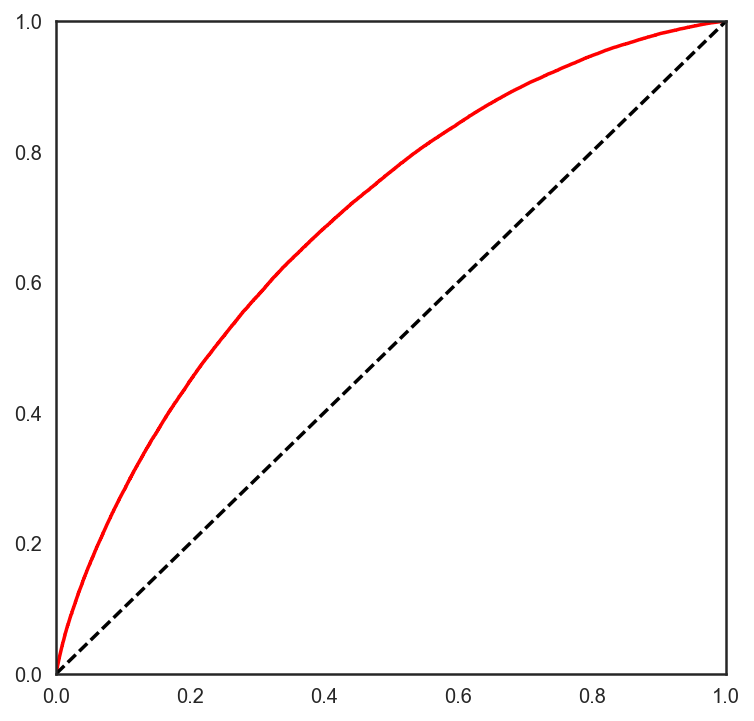

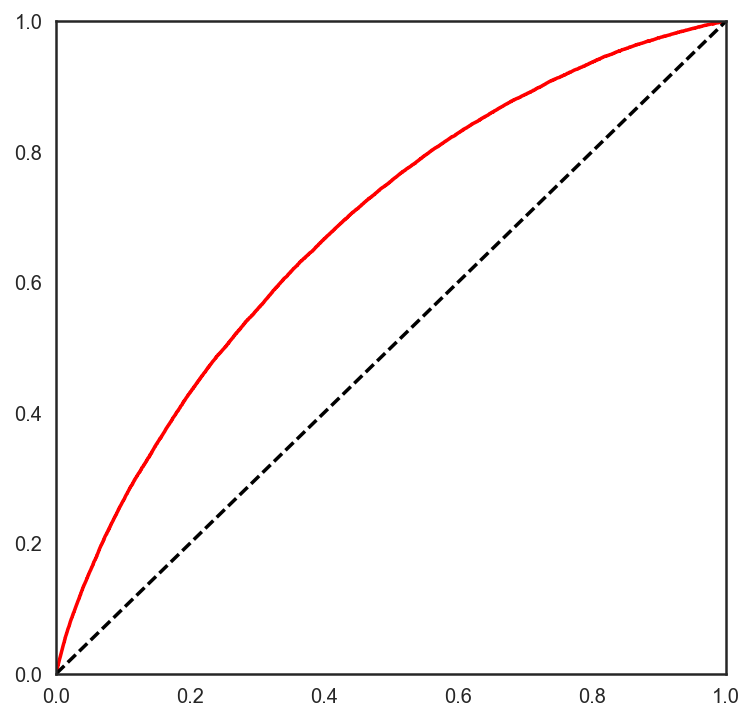

In [217]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(ally_true, ally_predp)
print(roc_auc_score(ally_true, ally_predp))

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

fpr, tpr, th = roc_curve(ally_trueV, ally_predpV)
print(roc_auc_score(ally_trueV, ally_predpV))

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

In [ ]:
# Compute F scores